# Auteur : PAMBOU MOUBOGHA Eddy Vianney
# Etudes : Master Sciences des Donnees et Systèmes Complexes
# Ecole : Université de Strasbourg
# Sujet :  Detection de glissements de terrain

In [16]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import csv
from datetime import date, datetime
import datetime
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.spatial.distance import euclidean
from sklearn.feature_selection import f_regression
from statsmodels.tsa.stattools import adfuller
from sklearn.manifold import TSNE
from DBCV import DBCV
import hdbscan
import csv
import multiprocessing
import itertools
import operator
import math
from dtaidistance import dtw
import seaborn as sns
import elevation
import json
plt.style.use('fivethirtyeight')
from osgeo import gdal 
from subprocess import Popen
import simplekml
import copy
from sklearn.cluster import DBSCAN

Error in callback <function _enable_matplotlib_integration.<locals>.configure_once at 0x7f9e27570700> (for post_run_cell):


ImportError: cannot import name 'configure_inline_support_orig' from 'matplotlib_inline.backend_inline' (/home/eost-user/miniconda3/lib/python3.9/site-packages/matplotlib_inline/backend_inline.py)

# Attributs des fichiers MM_TIO

* Lat : latitude (degré)
* Lon : longitude (degré)
* Vel : vitesse (mètre/jour)
* Topo : altitude d'un point (mètre)
* TS : serie temporelles de déplacement (mètre)

In [3]:
DATA_PATH = './donnees'

Error in callback <function _enable_matplotlib_integration.<locals>.configure_once at 0x7f9e27570700> (for post_run_cell):


ImportError: cannot import name 'configure_inline_support_orig' from 'matplotlib_inline.backend_inline' (/home/eost-user/miniconda3/lib/python3.9/site-packages/matplotlib_inline/backend_inline.py)

# Paramètres des géométries ascendante et descendante

In [12]:
# angle d'incidence du satellite en géométrie ascendante (angle entre la vertical et la direction du  satellite)
theta_asc = 0
# angle d'incidence du satelitte en géométrie descendante (angle entre la vertical et la direction du satellite)
theta_desc = 0
# difference angulaire des orbites des géométries ascendante et descendante
delta_alpha =  0
# déplacement le long de la ligne de visée en géométrie ascendante
d_los_asc = 0
# déplacement le long de la ligne de visée en géométrie descendante
d_los_dsc = 0
# # déplacement vertical
d_up = 0

Error in callback <function _enable_matplotlib_integration.<locals>.configure_once at 0x7f9e27570700> (for post_run_cell):


ImportError: cannot import name 'configure_inline_support_orig' from 'matplotlib_inline.backend_inline' (/home/eost-user/miniconda3/lib/python3.9/site-packages/matplotlib_inline/backend_inline.py)

# Chargement des données

In [4]:
def get_slope_value(file, lat, lon, ref='wgs84'):
    return float(os.popen('gdallocationinfo -valonly -%s %s %f %f' % (ref, file, lat, lon)).read())
    
def plot_raster(raster, cmap='gray'):
    values = raster.GetRasterBand(1).ReadAsArray()
    plt.figure()
    plt.imshow(values, cmap = cmap)
    plt.colorbar()
    plt.show()

In [6]:
def get_slope_value(ref, file, lat, lon):
        val = os.popen('gdallocationinfo -valonly -%s %s %f %f' % (ref, file, lat, lon)).read()
        if len(val) == 0:
            raise ValueError('La pente est non valide !')
        print(val)
        return  float(val)
    
ref = 'wgs84'
file = 'rasters/slope_map.tif'
lat = 6.662360
lon = 44.394169

val = os.popen('gdallocationinfo -valonly -%s %s %f %f' % (ref, file, lat, lon)).read()
print(val)

20.899076461792



In [331]:
dem = gdal.Open('rasters/31TGK_copernicus_dem.tif')
slope_map = gdal.DEMProcessing('rasters/slope_map.tif', dem, 'slope', computeEdges = True)

In [172]:
def load_data_from_json():
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk('./secteurs')):
        file_path = os.path.join(dirpath, filename)
        file = json.load(open(file_path))
        nb_lines   = p['local']['nb_lines']
        nb_columns = p['local']['nb_columns']
        for nl in range(nb_lines):
            for nc in range(nb_columns):
                latitude  = file['data'][nl][nc][0]
                longitude = file['data'][nl][nc][1]
                elevation = file['data'][nl][nc][2]
                velocity  = file['data'][nl][nc][3]
                quality   = file['data'][nl][nc][4]
                serie     = file['data'][nl][nc][5:]

In [9]:
def to_date(str):
    str_strp = str.strip()
    year, month, day = int(str_strp[0:4]), int(str_strp[4:6]), int(str_strp[6:8])
    return date(year, month, day)

def load_data(filename):

    # numéro de la ligne ou commence les données
    num_start = 44
    # numéro de la ligne ou se trouve la liste des dates
    num_list_dates = 40
    # attributs présent dans les données
    columns = ['id', 'Lat','Lon', 'Topo', 'Vel', 'Coer',' CosN', 'CosE', 'CosU']
    # dictionnaire stockant les données
    data = {column: [] for column in columns}
    # liste des dates 
    indexes = []
    # series temporelles
    series = []
    # liste de dataframes
    df_series = []

    with open(DATA_PATH + '/' + filename) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=",")
        line_count = 1 
        for row in csv_reader:
            if line_count == num_list_dates:
                indexes = [row[0].split(' ')[1]] + row[1:]
            if line_count >= num_start:
                # extraction des premiers attributs
                for i in range(len(columns)):
                    data[columns[i]].append(row[i])
                # extraction de l'attribut TS(série temporelle)
                series.append([float(v) for v in row[len(columns):]])
            line_count  += 1
        if len(indexes) != len(series[0]):
            print('Erreur : Les indexes et les valeurs ne correspondent pas')
        # convertir les index en date
        indexes = [d.strip()[0:8] for d in indexes]
        # créer une liste de dataframes, chacun contenant une série temporelle
        for serie in series:
            tmp_serie = pd.DataFrame({'displacement': pd.Series(serie, index=pd.DatetimeIndex(indexes))})
            tmp_serie.sort_index(inplace=True)
            df_series.append(tmp_serie)
        # creer un dataframe pour les autres attributs
        df = pd.DataFrame(data)
        for column in df.columns:
            df[column] = pd.to_numeric(df[column], errors='coerce')
        df.set_index('id')
        
    return df, df_series


def get_ids(df, column='id'):
    
    return df[column].tolist()
        
def impute(series, ids, pc=0.4):
    
    result = []
    ids_to_not_keep = []
    n_samples = len(series[0])
    
    for i in range(len(series)):
        if 100*(series[i].isnull().sum().sum()/n_samples) < pc:
            result.append(series[i].interpolate(limit_direction='both', inplace=False))
        else:
            ids_to_not_keep.append(ids[i])
            
    return result, ids_to_not_keep

def imputed(serie, index=None):
    
    # dataframe resultat
    result = None
    
    # liste des identifiants des valeurs manquantes
    rows_with_nan = [index for index, row in serie.iterrows() if row.isnull().any()]
    
    if index is None:
        result = serie.dropna(inplace=False)
        
    if isinstance(index, list):
        pass
        
    return result, rows_with_nan
        

# imputer les données
def impute_(ns_series, ew_series, pc=0.4):

    # nombre de mésures
    n = len(ns_series[0])
    
    # recupérer les series de la composante Nord-Sud qui ont un pourcentage de valeurs manquuantes inferieur à 50%
    ns_booleans  = [True if (ns_series[i].isnull().sum().sum()/n) < pc else False for i in range(len(ns_series))]
    # recupérer les series de la composante Est-Ouest qui ont un pourcentage de valeurs manquuantes inferieur à 50%
    ew_booleans  = [True if (ew_series[i].isnull().sum().sum()/n) < pc else False for i in range(len(ew_series))]
    # Conserver uniquement les points où la norme du vecteur vitesse est calculable
    booleans     = [True if i and j else False for i, j in zip(ns_booleans, ew_booleans)]
    
    # suppression des séries temporelles qui ont un pourcentage de valeurs manquantes supérieure ou égale à 0.5
    ns_series_c = [d for d in itertools.compress(ns_series, booleans)]
    ew_series_c = [d for d in itertools.compress(ew_series, booleans)]
    
    # interpoler les valeurs manquantes des les séries restantes
    for i in range(len(ns_series_c)):
        if ns_series_c[i].isnull().sum().sum() > 0:
            ns_series_c[i].interpolate(limit_direction='both', inplace=True)
        if ew_series_c[i].isnull().sum().sum() > 0:
            ew_series_c[i].interpolate(limit_direction='both', inplace=True)
            
    return ns_series_c[0].index, ew_series_c, ns_series_c

Error in callback <function _enable_matplotlib_integration.<locals>.configure_once at 0x7f4f6a37e670> (for post_run_cell):


ImportError: cannot import name 'configure_inline_support_orig' from 'matplotlib_inline.backend_inline' (/home/eost-user/miniconda3/lib/python3.9/site-packages/matplotlib_inline/backend_inline.py)

In [6]:
from sklearn import linear_model
reg = linear_model.LinearRegression()

serie = df_ns_ts[9]
X = np.array([abs((serie.index[0] - serie.index[n]).days) for n in range(len(serie.index))]).reshape(-1,1)
y = StandardScaler().fit_transform(serie)
reg.fit(X, y)
reg.coef_

def compute_slope(serie):
    displacement = serie['displacement']
    days = np.array([abs((serie.index[0] - serie.index[n]).days) for n in range(len(serie.index))])
    return  np.cov(displacement, days)[0][1] / np.var(np.array(days))

NameError: name 'df_ns_ts' is not defined

In [9]:
class TimeSerie():
    
    def __init__(self, id_, lat, lon, topo, serie):
        self.id   = id_
        self.lat  = lat
        self.lon  = lon
        self.topo = topo
        self.serie = self.interpolate(serie) if self.has_null_values(serie) else serie
        self.selected = False
    
    def has_null_values(self, serie):
        return True if serie.isnull().sum().sum() > 0 else False
    
    def interpolate(self, serie):
        return serie.interpolate(limit_direction='both', inplace=False)
        
    def set_selected(self):
        self.selected = !self.selected
        
    def get_linear_reg_pval(self, alpha):
        
        # transformer les index en durée pour pouvoire effectuer une regression linéaire
        X = np.array([abs((self.serie.index[0] - self.serie.index[n]).days) for n in range(len(self.serie.index))]).reshape(-1,1)
        
        # extraire la cible
        y = StandardScaler().fit_transform(self.serie)
        
        # calculer la p-value de la regression lineaire
        _, pval = f_regression(X,y.ravel())
        
        return  pval
    
    def set_linear_reg_pvalue(pvalue):
        self.linear_reg_pvalue = pvalue
        
    def set_slope(slope):
        self.slope = slope
        
    def get_slope_value(self, ref, file):
        val = os.popen('gdallocationinfo -valonly -%s %s %f %f' % (ref, file, self.lat, self.lon)).read()
        if len(val) == 0:
            raise ValueError('La pente est non valide !')
        return  float(val)
            
    def is_to_select(self, file, ref, min_slope, alpha):
        slope   = self.get_slope_value(ref, file)
        p_value = self.get_linear_reg_pval(alpha)
        # on filtre les pentes faibles 
        if slope < min_slope:
            return False
        # regression linéaire non significative
        if p_value > alpha:
            return False
        self.set_selected()
        return True

    def set_linear_reg_pvalue(self, pvalue):
        self.linear_reg_pvalue = pvalue
        
    def load(self, displacement):
        return serie.dropna(inplace=False)
    
    def has_enough_values(self, pc):
        return True if 100*(self.serie.displacement.isnull().sum().sum()/len(self.serie)) < pc else False
        
    def normalize(self):
        return StandardScaler().fit_transform(self.serie)
        
    def compute_inst_vel(self):
        vels =  []
        for i in range(1, len(self.serie)-1):
            duration = (self.serie.index[i+1] - self.serie.index[i-1]).days
            displacement = self.serie.iloc[i+1].values[0] - self.serie.iloc[i-1].values[0]
            vels.append(displacement / duration)
        # supprimer le premier et le dernier index (formule non applicable)
        return pd.DataFrame(vels, index=self.serie.index[1:-1], columns=['vel'])
    
    # la copie renvoie bien un nouvel objet, il n'y a pas d'effets de bord
    def smooth(self, ampl=2):
        serie = self.serie.copy()
        sigma = math.sqrt(serie.var())
        for i in range(len(serie)):
            if abs(serie.iloc[i].displacement) > ampl*sigma:
                # remplacer les anomalies par des valeurs manquantes
                serie.iloc[i, serie.columns.get_loc('displacement')]= np.nan
        return self.deepcopy(serie.interpolate(limit_direction='both', inplace=False))
    
    def detect_non_moving_serie(self, alpha):
        
        # transformer les index en durée pour pouvoire effectuer une regression linéaire
        X = np.array([abs((self.serie.index[0] - self.serie.index[n]).days) for n in range(len(self.serie.index))]).reshape(-1,1)
        
        # extraire la cible
        y = StandardScaler().fit_transform(self.serie)
        
        # calculer la p-value de la regression lineaire
        _, pval = f_regression(X,y.ravel())
        self.set_linear_reg_pvalue(pval)
        
        # calculer la spente selon sklearn
        reg = LinearRegression(fit_intercept=True).fit(X,y)
        
            
        # eliminer le bruit si la regression n'est pas significative (bourrage de zeros)
        if pval > alpha:
            #return self.clone(pd.DataFrame(0.0, index=self.serie.index, columns=self.serie.columns))
            return self.deepcopy(pd.DataFrame(0.0, index=self.serie.index, columns=self.serie.columns))  
        else:
            #return self.clone(self.serie.copy())
            return self.deepcopy(self.serie)
    
    def transform(self, alpha):
        return self.smooth().detect_non_moving_serie(alpha)
        
    def deepcopy(self, serie):
        clone = copy.deepcopy(self)
        clone.set_serie(serie)
        return clone
    
    def set_serie(self,serie):
        self.serie = serie
        
    def compute_adfuller(self, ts):
        adf_result = adfuller(ts)
        adf_output = pd.Series(adf_result[0:4],index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
        for key, value in adf_result[4].items():
            adf_output['Critical Value (%s)'%(key)] = value
        return adf_output[1]
        
    # Il y a un souci avec cette fonction
    def clone(self, serie):
        return TimeSerie(self.id, self.lat, self.lon, self.topo, serie)
    
    def get_days(dates):
        days = []
        for i in range(len(dates)):
            days.append(abs((dates[0] - dates[i]).days ))
        return days

    def get_Xy(self, serie):
        X = get_days(serie.index)
        y = StandardScaler().fit_transform(serie)
        return np.array(X).reshape(-1,1), y
    

In [10]:
class DataFromImageCorrelation():
    
    def __init__(self, raster_folder_name, dem_filename, geo, ns, ew, pc=0.4, alpha=0.05, ref='wgs84'):
        self.ns, self.ew  = self.load(geo, ns, ew, pc)
        self.compute_slope_map(raster_folder_name, dem_filename)
        self.n_cores = multiprocessing.cpu_count()
        self.non_filtered_ids = []
        self.magnitudes = None
        self.pc = pc 
        self.alpha = alpha
        self.ref = ref
    
    def set_slope_map_path(self, slope_map_path):
        self.slope_map_path = slope_map_path
        
    def select_pixel(self, n, min_slope):
        return (self.ns[n].is_to_select(self.slope_map_path, self.ref, min_slope, self.alpha) or 
                self.ew[n].is_to_select(self.slope_map_path, self.ref, min_slope, self.alpha))
    
    def load_raster(self, raster_folder_name, raster_filename):
        return gdal.Open(raster_folder_name + '/' +  raster_filename)
        
    def compute_slope_map(self, raster_folder_name, dem_name):
        dem = None
        slope_map = None
        slope_map_name = dem_name.split('.')[0] + '_' + 'slope_map.tif'
        slope_map_path = raster_folder_name + '/' + slope_map_name
        if not os.path.isfile(slope_map_path):
            dem = gdal.Open(raster_folder_name + '/'+ dem_name)
            slope_map = gdal.DEMProcessing(slope_map_path, dem, 'slope', computeEdges = True)
        self.set_slope_map_path(slope_map_path)
    
    def empty_non_filtered_ids(self):
        self.non_filtered_ids.clear()
        
    def add_non_filtered_ids(self, n):
        self.non_filtered_ids.append(n)
    
    def load(self, geo, ns, ew, pc):
        ns_r, ew_r = [], []
        for i in range(len(ns)):
            # vérifier que les séries temporelles comporte un pourcentage de valeurs null inférieure à pc et on des id identiques
            if ns[i].isnull().sum().sum()/len(ns[i]) < pc:
                ns_ts = ns[i].interpolate(limit_direction='both', inplace=False)
                ew_ts = ew[i].interpolate(limit_direction='both', inplace=False)   
                ns_r.append(TimeSerie(geo.iloc[i].id, geo.iloc[i].Lat, geo.iloc[i].Lon, geo.iloc[i].Topo, ns_ts))
                ew_r.append(TimeSerie(geo.iloc[i].id, geo.iloc[i].Lat, geo.iloc[i].Lon, geo.iloc[i].Topo, ew_ts))
        return ns_r, ew_r
    
    def compute_vel(self, ns_component, ew_component):
        return math.sqrt(ns_component * ns_component + ew_component * ew_component)
    
    def compute_magnitude(self, boolean, min_slope=None):
        magnitudes = []
        ns_vel_ts = None
        ew_vel_ts = None
        if boolean:
            ns_vel_ts = self.compute_inst_vels(self.ns)
            ew_vel_ts = self.compute_inst_vels(self.ew)
        else:
            ns, ew    = self.transform(min_slope)
            ns_vel_ts = self.compute_inst_vels(ns)
            ew_vel_ts = self.compute_inst_vels(ew)
        for i in range(len(ns_vel_ts)):
            vels = []
            column = ns_vel_ts[0].columns[0]
            for ns_component, ew_component in zip(ns_vel_ts[i][column], ew_vel_ts[i][column]):
                vels.append(self.compute_vel(ns_component, ew_component))
            df = pd.DataFrame(vels, index=ns_vel_ts[0].index, columns=['magnitude'])
            magnitudes.append(df)
        return magnitudes
    
    def compute_inst_vel(self, ts):
        vels =  []
        for i in range(1, len(ts.serie)-1):
            duration = (ts.serie.index[i+1] - ts.serie.index[i-1]).days
            displacement = ts.serie.iloc[i+1].values[0] - ts.serie.iloc[i-1].values[0]
            vels.append(displacement / duration)
        return pd.DataFrame(vels, index=ts.serie.index[1:-1], columns=['vel'])
    
    def compute_inst_vels(self, ts):
        with multiprocessing.Pool(self.n_cores) as p:
            results = p.map(self.compute_inst_vel, ts)
            return results
        
    def transform(self, min_slope):
        ns, ew = [], []
        self.empty_non_filtered_ids()
        for n in range(len(self.ns)):
            if self.select_pixel(n, min_slope):
                ns.append(self.ns[n].smooth().detect_non_moving_serie(self.alpha))
                ew.append(self.ew[n].smooth().detect_non_moving_serie(self.alpha))
                self.add_non_filtered_ids(n)
        return ns, ew
    
    # renvoyer les données pour effectuer le clustering
    # si on n'interesse qu'à la forme, il faut normaliser les données
    def prepare(self, min_slope):
        self.set_magnitudes(self.compute_magnitude(False, min_slope))
    
    # for the moment, we only normalize velocity time series
    # use this method to use euclidian distance
    def normalize(self):
        return np.array([StandardScaler().fit_transform(df).reshape(len(df)) for df in self.magnitudes])
    
    def set_magnitudes(self, magnitudes):
        self.magnitudes = magnitudes
        
    # use this matrix to use DTW with HDBSCAN
    def compute_similarity_matrix(self):
        size = len(self.magnitudes)
        distances_matrix = np.zeros(shape=(len(self.magnitudes), len(self.magnitudes)))
        for n in range(size):
            for m in range(n , size):
                u = StandardScaler().fit_transform(self.magnitudes[n])
                v = StandardScaler().fit_transform(self.magnitudes[m])
                dist = dtw.distance(u, v)
                distances_matrix[n, m] = dist
                distances_matrix[m, m] = dist
        return distances_matrix
    
    def filter_vel(self, thr):
        return True
        
        

In [102]:
class Visualization():

    
    def __init__(self):
        pass
    
    def plot_displacement(self, ts):
        
        days = get_days(ns_ts.index)
        fig, ax = plt.subplots(figsize=(15,5))
    
        ax[0].plot(ns_ts['displacement'], color='blue', label='NS displacement (m)', marker='o', linewidth=2)
        ax[1].plot(ew_ts['displacement'], color='orange', label='EW displacement (m)', marker='o', linewidth=2)
        
        plt.legend()
        plt.legend(loc='best')
        plt.show()
    
    def plot_displacement_vel(self, ns_ts, ew_ts):
        
        days = get_days(ns_ts[0].index)

        fig, ax_left = plt.subplots(figsize=(15,5))
        ax_right = ax_left.twinx()

        p1, = ax_left.plot(days, df_series[4]['displacement'], color='blue', label='NS displacement (m)')
        p2, = ax_right.plot(days, df_series[4]['displacement'], color='orange', label='EW displacement(m)')

        ax_left.set_xlabel("number of days since the first measure")
        ax_left.set_ylabel("displacement")
        ax_right.set_ylabel("velocity")

        lns = [p1, p2]

        ax_left.legend(handles=lns, loc='best')
        fig.tight_layout()
        plt.show()
        
    def plot_disp_ns_ew(self, ns_ts, ew_ts):

        fig, ax = plt.subplots(2, 1, figsize=(15,10))

        ax[0].plot(ns_ts, color='blue', label='displacement (m)', marker='o', linewidth=2)
        ax[0].set_title('NS cumulative displacement')
        ax[0].set_xlabel('time')
        ax[0].set_ylabel('displacement')
        ax[0].legend()

        ax[1].plot(ew_ts, color='orange', label='displacement (m)', marker='o', linewidth=2)
        ax[1].set_title('EW cumulative displacement')
        ax[1].set_xlabel('time')
        ax[1].set_ylabel('displacement')
        ax[1].legend()
        
        fig.tight_layout()
        plt.show()
        
        
    def plot_disp_vel(self, ns_ts, ew_ts, vels):

        fig, ax = plt.subplots(3, 1, figsize=(15,10))

        ax[0].plot(ns_ts, color='blue', label='displacement (m)', marker='o', linewidth=2)
        ax[0].set_title('NS cumulative displacement')
        ax[0].set_xlabel('time')
        ax[0].set_ylabel('displacement')
        ax[0].legend()

        ax[1].plot(ew_ts, color='orange', label='displacement (m)', marker='o', linewidth=2)
        ax[1].set_title('EW cumulative displacement')
        ax[1].set_xlabel('time')
        ax[1].set_ylabel('displacement')
        ax[1].legend()

        ax[2].plot(vels, color='green', label='velocity (m/day)', marker='o', linewidth=2)
        ax[2].set_title('Velocity magnitude')
        ax[2].set_xlabel('time')
        ax[2].set_ylabel('velocity')
        ax[2].legend()

        fig.tight_layout()
        plt.show()
        
    def plot_series(series, num_rows=4, num_cols=5, colormap='tab20'):
        
        plot_kwds = {'alpha' : 0.25, 's' : 10, 'linewidths':0}
        fig, axs = plt.subplots(num_rows, num_cols, figsize=(25,25))
        cmap = plt.get_cmap(colormap)
        colors = [cmap(i) for i in np.linspace(0,1,num_rows*num_cols)]

        for num_row in range(num_rows):
            for num_col in range(num_cols):
                if num_row*num_cols + num_col < len(series):
                    axs[num_row, num_col].plot(series[num_row*num_cols + num_col], color=colors[num_row*num_cols + num_col], marker='o', markerfacecolor='white')
                    #axs[num_row, num_col].set_title('serie: %s'%(self.names[num_row*num_cols + num_col].split('.')[0]))

        plt.show()

In [90]:
class Utility():
    
    def __init__(self):
        pass

    def get_season(self, date):
        
        for season in seasons:
            name  = season[0]
            start = season[1].replace(year=date.year)
            end   = season[2].replace(year=date.year)
            if start <= date <= end
                return name
            
    def count_samples_per_season(self, dates):
    
        samples_per_season = {'winter': 0, 'spring': 0, 'summer': 0, 'autumn': 0}
        for date in dates:
            samples_per_season[get_season(date)] += 1

        return samples_per_season
    
    def get_days(self, dates):
        
        days = []
        for i in range(len(dates)):
            days.append(abs((dates[0] - dates[i]).days ))
        return days

SyntaxError: invalid syntax (<ipython-input-90-0508635d9d2a>, line 12)

In [13]:
# chargement de la composante  Est-Ouest du mouvement du sol
df_ew, df_ew_ts = load_data('MM_TIO_EW_31TGK_20151227_to_20200906.csv')
# chargement de la composante Nord-Sud du mouvement du sol
df_ns, df_ns_ts = load_data('MM_TIO_NS_31TGK_20151227_to_20200906.csv')

In [15]:
n = 1000
RASTER_FOLDER_PATH = 'rasters'
DEM_FILENAME =  '31TGK_copernicus_dem.tif'
Data = DataFromImageCorrelation(RASTER_FOLDER_PATH, DEM_FILENAME, df_ew.head(n), df_ns_ts[:n], df_ew_ts[:n])

# Visualisation

In [16]:
# visualisation des vitesses brutes (calculées à partir des déplacement brutes)
n = 0
raw_magnitudes = Data.compute_magnitude(True)
viz = Visualization()
viz.plot_disp_vel(Data.ns[n].serie, Data.ew[n].serie, raw_magnitudes[n])

Process ForkPoolWorker-3:
Process ForkPoolWorker-1:
Process ForkPoolWorker-2:
Traceback (most recent call last):
  File "/home/eost-user/miniconda3/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
Process ForkPoolWorker-4:
  File "/home/eost-user/miniconda3/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/eost-user/miniconda3/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/eost-user/miniconda3/lib/python3.9/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/home/eost-user/miniconda3/lib/python3.9/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/home/eost-user/miniconda3/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-a95ae9c86253>", line 76, 

KeyboardInterrupt: 

# Calcul des profils de vitesse

In [17]:
Data.prepare(min_slope=5)

In [198]:
#from datetime import datetime
Y = 2000
seasons  = [('winter', date(Y,  1,  1), date(Y,  3, 20)),
           ('spring', date(Y,  3, 21),  date(Y,  6, 20)),
           ('summer', date(Y,  6, 21),  date(Y,  9, 22)),
           ('autumn', date(Y,  9, 23),  date(Y, 12, 20)),
           ('winter', date(Y, 12, 21),  date(Y, 12, 31))]

        
def plot_pie(labels, values):

    fig1, ax1 = plt.subplots(figsize=(5,5))
    ax1.pie(values, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax1.axis('equal') 

    plt.show()
    
def plot_displacement(ns_ts, ew_ts):
    
    days = get_days(ns_ts.index)
    fig, ax = plt.subplots(figsize=(15,5))
    
    ax.plot(ns_ts['displacement'], color='blue', label='NS displacement (m)', marker='o', linewidth=2)
    ax.plot(ew_ts['displacement'], color='orange', label='EW displacement (m)', marker='o', linewidth=2)
    
    plt.legend(loc='best')
    
def plot_displacement_velocity(ns_ts, ew_ts):

    days = get_days(ns_ts[0].index)

    fig, ax_left = plt.subplots(figsize=(15,5))
    ax_right = ax_left.twinx()
    
    p1, = ax_left.plot(days, df_series[4]['displacement'], color='blue', label='NS displacement (m)')
    p2, = ax_right.plot(days, df_series[4]['displacement'], color='orange', label='EW displacement(m)')

    ax_left.set_xlabel("number of days since the first measure")
    ax_left.set_ylabel("displacement")
    ax_right.set_ylabel("velocity")

    lns = [p1, p2]
    
    ax_left.legend(handles=lns, loc='best')
    fig.tight_layout()
    plt.show()nb_lines': 50, 'nb_columns': 100,

SyntaxError: invalid syntax (<ipython-input-198-0e252e6238f2>, line 47)

# Clustering par Densité

## HDBSCAN

In [139]:
class Clustering():
    
    def __init__(self, data):
        self.data = data
        self.result = None
        self.n_clusters = None
        
    def cluster(self, min_cluster_size, precomputed=False):
        if not precomputed: 
            self.result = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, gen_min_span_tree=True).fit(self.data.normalize())
        else:
            print('lll')
            self.result = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, gen_min_span_tree=True, metric='precomputed').fit(self.data.compute_similarity_matrix())

    def get_n_clusters(self):
        return 0 if self.result.labels_.max() < 0 else self.result.labels_.max() + 1
    
    def visualize(self):
        projection = TSNE().fit_transform(self.data.normalize())
        color_palette = sns.color_palette('Paired', self.result.labels_.max() + 1 )
        cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in self.result.labels_]
        cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, self.result.probabilities_)]
        plt.scatter(*projection.T, s=20, c=cluster_member_colors , linewidth=0, alpha=0.25)
    plt.show()
        
    def plot_cluster_distribution(self, colormap='Dark2'):
        v_count = dict()
        cmap = plt.get_cmap(colormap)
        colors = [cmap(i) for i in np.linspace(0, 1, self.result.labels_.max() + 1)]
        for label in self.result.labels_:
            if label != -1:
                if label in v_count.keys():
                    v_count[label] += 1
                else:
                    v_count[label] = 1
        pd.Series({k: v for k, v in sorted(v_count.items(), key=lambda item: item[0])}).plot(kind='bar', color=colors)
        return v_count
    
    def get_data_from_class(self, num_label):
        data = []
        for i in range(len(self.result.labels_)):
            if self.result.labels_[i] == num_label:
                data.append(self.data[i])
        return data
    
    def plot_cluster_result(self, n_cols=3):
        labels = self.result.labels_
        n_clusters = labels.max() + 1
        n_rows = int(n_clusters / n_cols) if n_clusters % n_cols == 0 else int(math.ceil(n_clusters / n_cols))
        fig, axs = plt.subplots(n_rows, n_cols, figsize=(25,15))
        for num_cluster in range(n_clusters):
            for serie_index in range(len(self.data.magnitudes)):
                if labels[serie_index] == num_cluster:
                    axs[int(num_cluster / n_cols), num_cluster % n_cols].plot(self.data.magnitudes[serie_index], c='blue', alpha=0.2)
            axs[int(num_cluster / n_cols), num_cluster % n_cols].set_title('Cluster %d'%(num_cluster + 1))
        fig.tight_layout()
        
    # créer un fichier csv contenant les champs : id, lat, lon, numero de la classe
    def save_result(self):

        fieldnames = ['id', 'Lat', 'Lon', 'cluster']
        rows = []
        
        for n in range(len(self.data.ns)):
            rows.append({'id': int(self.data.ns[n].id), 'Lat': self.data.ns[n].lat, 'Lon': self.data.ns[n].lon, 'cluster': self.result.labels_[n]})

        with open('clustering_result.csv', 'w', encoding='UTF8', newline='') as f:
            writer = csv.DictWriter(f, fieldnames=fieldnames)
            writer.writeheader()
            writer.writerows(rows)
            
    def generate_kml_file(self, scale=2):
        labels = self.result.labels_
        if labels.max() > -1:
            icon_links, scales = self.generate_icones(labels)
            kml=simplekml.Kml()
            fol = kml.newfolder(name="HDBSCAN Clustering")
            labels = self.result.labels_
            for i, n in enumerate(self.data.non_filtered_ids, 0):
                if labels[i] > - 1:
                    pnt = fol.newpoint(coords=[(self.data.ns[n].lat, self.data.ns[n].lon)])
                    pnt.iconstyle.icon.href = icon_links[labels[i]]
                    pnt.style.labelstyle.scale = scales[labels[i]]
            kml.save('clustering_result.kml')
        else:
            print('Hdbscan only found outliers. kml file cannot be generated !')
    
    #http://tancro.e-central.tv/grandmaster/markers/google-icons/mapfiles-ms-micons.html
    def generate_icones(self, labels, scale=2):
        BASE = 'http://maps.google.com/mapfiles/ms/micons/'
        scales = None
        colors = ['blue', 'red', 'yellow', 'green', 'orange', 'purple', 'pink']
        icon_links = [BASE + color + '-dot.png' for color in (colors + ['Itblue'])[:]] + [BASE + color + '.png' for color in (colors + ['lightblue'])[:]]
        n_clusters = labels.max() + 1
        if n_clusters > len(icon_links):
            q = int(n_clusters / len(icon_links))
            r = n_clusters - q*len(icon_links)
            icon_links = (icon_links*q)[:] + icon_links[:r]
            scales = [scale*t for t in range(len(icon_links))]
        else:
            scales = [scale]*n_clusters
        return icon_links, scales
    
    # coefficient de silhouette ?
    def validate(self):
        return DBCV(self.data.magnitudes, self.result.labels_, dist_function=euclidean)

/home/eost-user/miniconda3/lib/python3.9/site-packages/hdbscan/hdbscan_.py:217: UserWarning: Cannot generate Minimum Spanning Tree; the implemented Prim's does not produce the full minimum spanning tree 
  warn('Cannot generate Minimum Spanning Tree; '


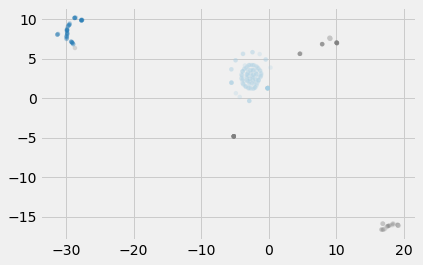

In [140]:
import simplekml
clustering = Clustering(Data)
clustering.cluster(min_cluster_size=50, precomputed=False)
clustering.visualize()
clustering.generate_kml_file()

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

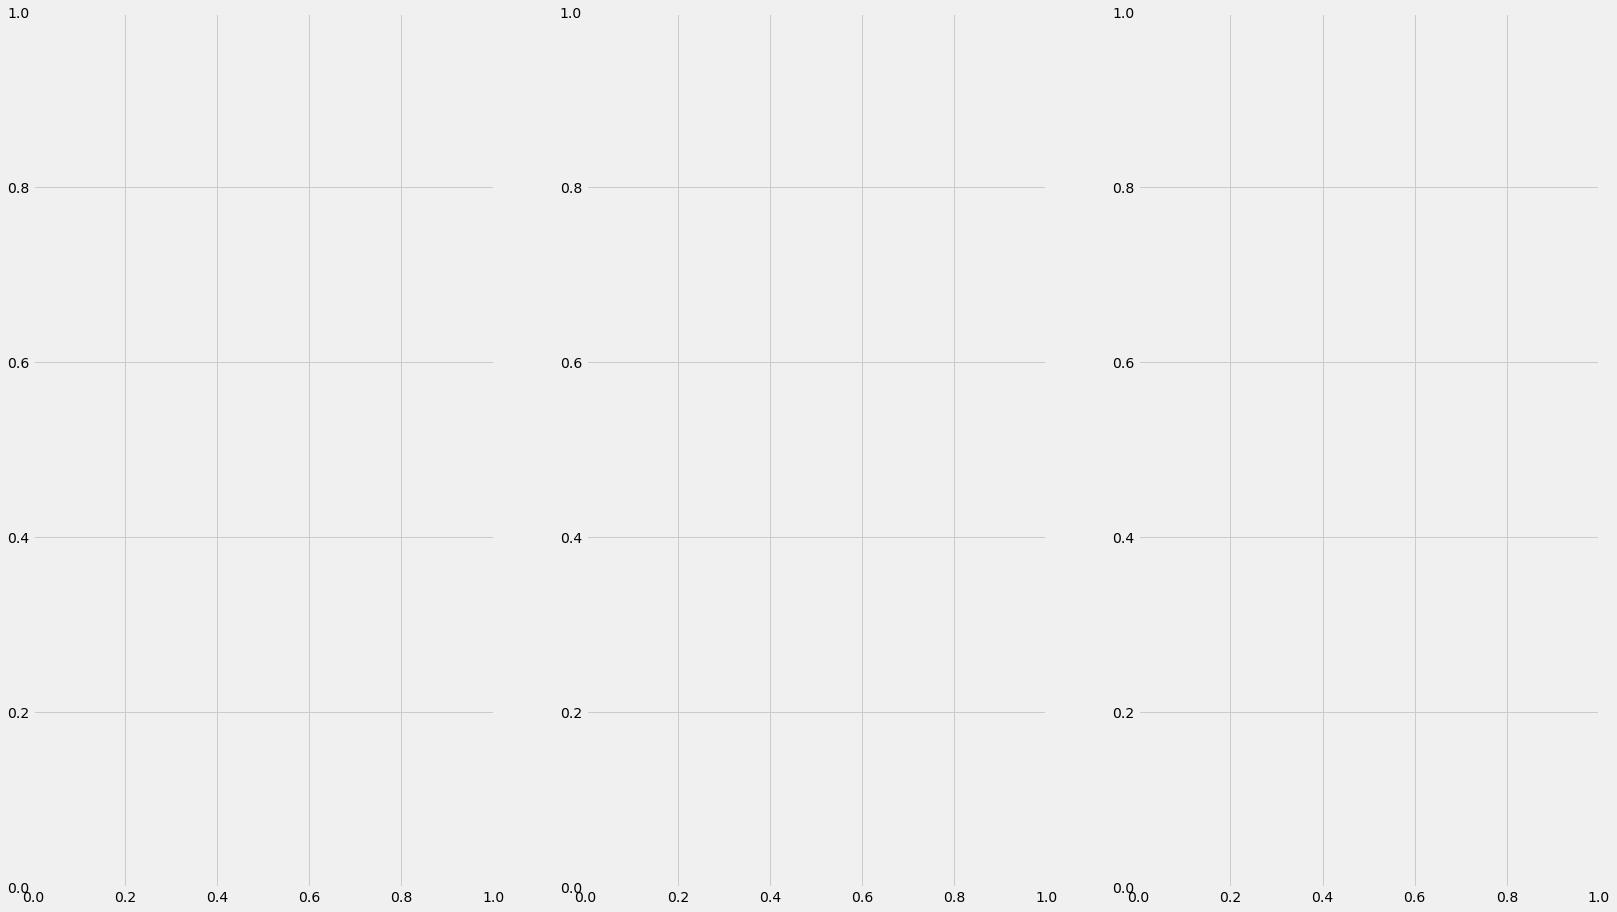

In [143]:
clustering.plot_cluster_result()

In [43]:
 def get_pval(serie, alpha=0.05):
        
        # transformer les index en durée pour pouvoire effectuer une regression linéaire
        X = np.array([abs((serie.index[0] - serie.index[n]).days) for n in range(len(serie.index))]).reshape(-1,1)
        
        # extraire la cible
        y = StandardScaler().fit_transform(serie)
        
        # calculer la p-value de la regression lineaire
        _, pval = f_regression(X,y.ravel())
        
        if pval > alpha:
            print('non significative')
        else:
            print('significative')
            
def smooth(serie_, ampl=2):
    serie = serie_.copy()
    sigma = math.sqrt(serie.var())
    for i in range(len(serie)):
        if abs(serie.iloc[i].displacement) > ampl*sigma:
            # remplacer les anomalies par des valeurs manquantes
            serie.iloc[i, serie.columns.get_loc('displacement')]= np.nan
    return serie.interpolate(limit_direction='both', inplace=False)

In [128]:
#s = pd.DataFrame(0.0, index=Data.ns[n].serie.index, columns=['pp'])
get_pval(Data.ns[n].serie)
# attention il y a bug quelque part, il faut s'assurer de calculer la regression uniquement après avoir lisser
# les pics

significative


In [76]:
def compute_adfuller(ts):
    adf_result = adfuller(ts)
    adf_output = pd.Series(adf_result[0:4],index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key, value in adf_result[4].items():
        adf_output['Critical Value (%s)'%(key)] = value
    return adf_output[1]

In [127]:
t = compute_adfuller(Data.ns[n].serie)
if t < 0.05:
    print('serie stationnaire')
else:
    print('non stationnaire')
len(Data.non_filtered_ids)

serie stationnaire


274

In [125]:
index

[87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 118,
 119,
 120,
 121,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 242,
 243,
 244,
 245,
 250,
 251,
 254,
 255,
 256,
 257,
 258,
 259,
 260,
 261,
 262,
 263,
 264,
 280,
 281,
 282,
 283,
 284,
 285,
 286,
 287,
 288,
 289,
 290,
 291,
 379,
 380,
 381,
 382,
 383,
 384,
 385,
 386,
 387,
 388,
 389,
 390,
 391,
 392,
 393,
 394,
 395,
 396,
 397,
 398,
 399,
 400,
 401,
 402,
 403,
 404,
 405,
 406,
 407,
 410,
 411,
 412,
 413,
 447,
 448,
 449,
 450,
 451,
 452,
 453,
 454,
 455,
 456,
 457,
 458,
 459,
 534,
 535,
 536,
 537,
 542,
 543,
 546,
 547,
 548,
 549,
 550,
 551,
 552,
 553,
 554,
 555,
 556,
 557,
 558,
 559,
 560,
 572,
 573,
 574,
 575,
 576,
 577,
 578,
 579,
 580,
 581,
 582,
 583,
 670,
 671,
 672,
 673,
 674,
 675,
 676,
 677,
 678,
 679,
 680,
 681,
 682,
 683,
 684,

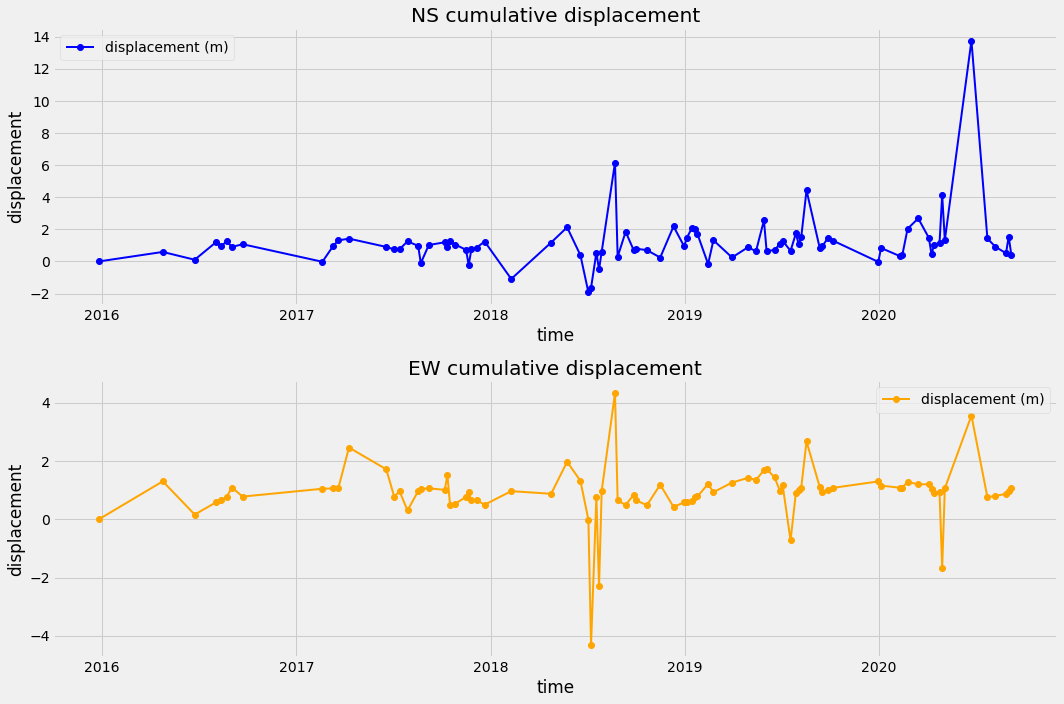

In [126]:
viz = Visualization()
index = Data.non_filtered_ids
n = 100
viz.plot_disp_ns_ew(Data.ns[n].serie, Data.ew[n].serie)

# ICA

In [123]:
# With ICA
# S = W X
# S_ = fastICA().fit_transform(X)
# W : matrice des poids
# X : matrice des observations. X.shape = (n_samples, n_sources)
# S: les sources
# S_ : les sources reconstitués . S_.shape = X.shape

# With PCA :
# r = PCA().fit_transform(X)
# r: les sources reconstutées avec l'ACP

# temporal ICA 
# X = A S
# X is the mixed observations (contains the mixed as rows), X.shape = (n_pixel, n_samples)
# A.shape = (n_source, n_pixel)
# S contains the unknown sources of as rows vectors S.shape = (n_source, n_samples)

from sklearn.datasets import load_digits
from sklearn.decomposition import FastICA

def reshape(data):
    n_pixels =  len(data)
    n_samples = len(data[0])
    return  np.array(data).reshape(n_pixels, n_samples)
X = reshape(Data.magnitudes)

In [109]:
ica = FastICA(n_components=3)
S_ = ica.fit_transform(X)

# Significativité des régressions linéaires
* p-value : probabilité que la pente soit nulle
* Hypothèse nulle HO : la pente de la droite de regression est nulle  (vitesse moyenne non significative)
* si la p-value est inférieure à 0.05 alors l'hypothèse nulle est rejetée (vitesse moyenne est significative).

In [75]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from statsmodels.api import add_constant
import statsmodels.api as sm

In [90]:
def get_days(dates):
    days = []
    for i in range(len(dates)):
        days.append(abs((dates[0] - dates[i]).days ))
    return days

def get_xy(serie):
    X = get_days(serie.index)
    y = StandardScaler().fit_transform(serie)
    return np.array(X).reshape(-1,1), y

def compute_linear_regression(X,y):
    
    X_ = add_constant(X)
    mod = sm.OLS(y,X_)
    fii = mod.fit()
    
    return fii.params, fii.pvalues

def compute_slope(displacement, days):
    
    return  np.cov(displacement, days)[0][1] / np.var(np.array(days))

## Test de Dickey-Fuller augmenté (ADF)
La série temporelle est considérée comme stationnaire si la valeur p est faible (selon l’hypothèse nulle) et si les valeurs critiques à des intervalles de confiance de 1%, 5%, 10% sont aussi proches que possible des statistiques de l’ADF (Augmented Dickey-Fuller)

# Réechantillonage des données

# Etude de la saisonnalité